Neural Simulation-Based Inference in a nutshell
===

Use well trained Neural Networks as likelihood ratio surrogates to diectly fit parameters of interest - **no need for histograms or Poisson likelihoods.** 

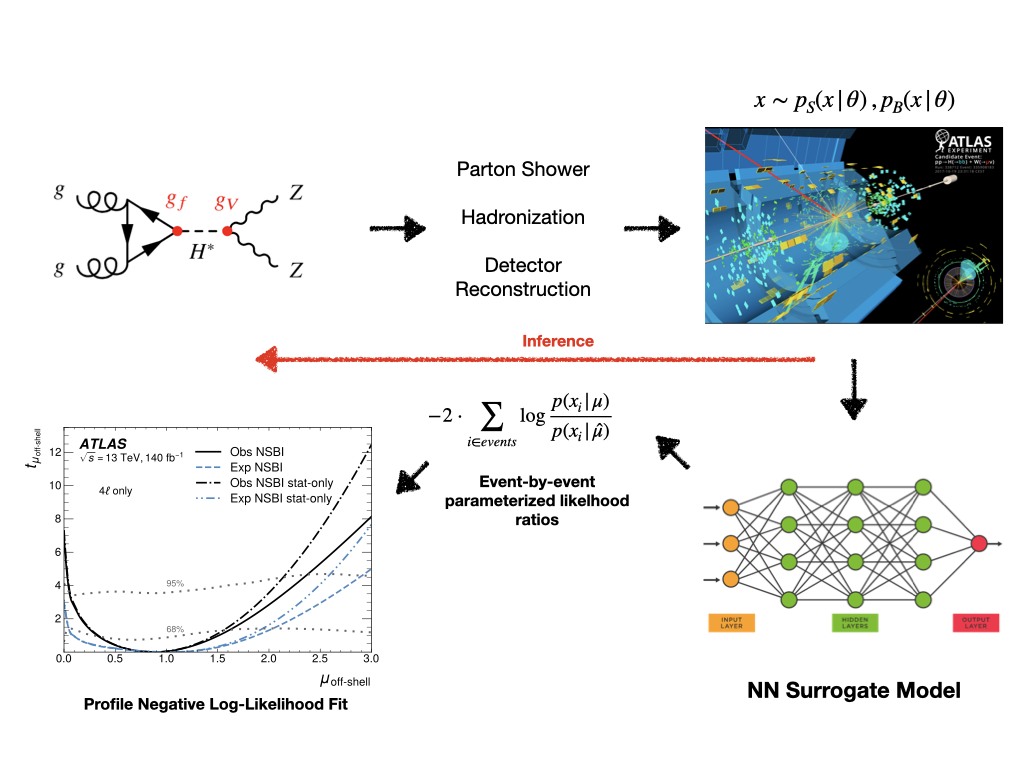

Workflow with CMS ttbar open data
===
Neural Simulation-Based Inference, as the name suggests relies heavily on the robust simulation modelling of probability distributions. To train NNs that act as unbiased and low-variance proxies of these very complex probability distributions requires also that they see enough simulated training events. 

With the CMS open ttbar data, the signal process is easily distinguishable from background and hence the **preselections chosen here have been made as loose as possible to retain maximum background simulation statistics**. 

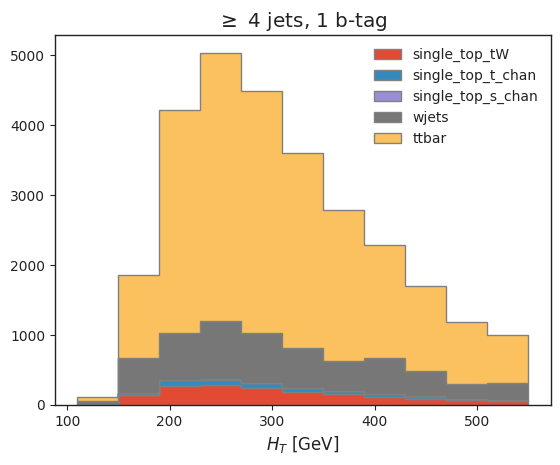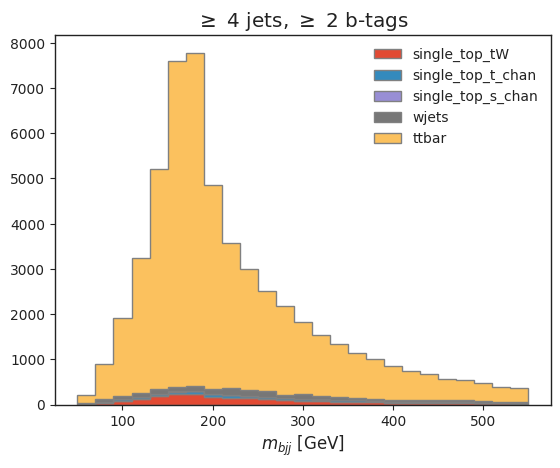

No b-tagging requirements are made, nor are a minimum number of four jets in the final state enforced. **This is only a toy version of the original analysis to illustrate the NSBI workflow.** 

Since adding jet-related features like b-tagging can also isolate phase spaces with low background statistics, only the single lepton kinematics $(p_T, \eta, \phi)$ and sum of jet pT $H_T = \sum_\text{jets} p_T$ are used as multi-dimensional training features for the modelling of likelihood ratios. 

In an ideal scenario with enough Monte Carlo statistics to train low-variance NNs, the full final-state information is used in an NSBI analysis to maximize sensivity - reemphasizing the toy nature of the analysis presented in this tutorial.

# Environment needed to run this tutorial:

On the UChicago AF, use the `ml-platform:latest` image with additional dependencies installed manually:

```
coffea  ==  0.7.25
jax     ==  0.4.13
jaxlib  ==  0.4.13
```

A full pip list is shown towards the end of the notebook.

In [31]:
import logging
import time
import pandas as pd

import awkward as ak
from coffea import processor
from coffea.nanoevents import NanoAODSchema
from coffea.analysis_tools import PackedSelection
import copy
import hist
import matplotlib.pyplot as plt
import numpy as np
import pyhf

import mplhep as hep
hep.style.use(hep.style.ATLAS)

In [32]:
N_FILES_MAX_PER_SAMPLE = 1
USE_DASK=False
USE_SERVICEX=False
USE_SAVED_FEATURES=False

path_prefix = '/home/jaySandesara/NSBI_workflow_tutorial/cms_ttbar_open_data/'

# Path for saving interemdiate objects, like datasets and NN predictions
saved_data = f'{path_prefix}cached_data/'

In [33]:
# Need to change current working directory when using Visual studio with remote session
import os
os.chdir(f"{path_prefix}")
import utils 

In [34]:
fileset = utils.file_input.construct_fileset(
    N_FILES_MAX_PER_SAMPLE,
    use_xcache=False,
    af_name="coffea_casa",  
    input_from_eos=False,
    xcache_atlas_prefix=None
)

print(f"processes in fileset: {list(fileset.keys())}")
print(f"\nexample of information in fileset:\n{{\n  'files': [{fileset['ttbar__nominal']['files'][0]}, ...],")
print(f"  'metadata': {fileset['ttbar__scaleup']['metadata']}\n}}")

processes in fileset: ['ttbar__nominal', 'ttbar__scaledown', 'ttbar__scaleup', 'ttbar__ME_var', 'ttbar__PS_var', 'single_top_s_chan__nominal', 'single_top_t_chan__nominal', 'single_top_tW__nominal', 'wjets__nominal']

example of information in fileset:
{
  'files': [https://xrootd-local.unl.edu:1094//store/user/AGC/nanoAOD/TT_TuneCUETP8M1_13TeV-powheg-pythia8/cmsopendata2015_ttbar_19980_PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1_00000_0000.root, ...],
  'metadata': {'process': 'ttbar', 'variation': 'scaleup', 'nevts': 1278695, 'xsec': 729.84}
}


In [35]:
NanoAODSchema.warn_missing_crossrefs = False # silences warnings about branches we will not use here

executor = processor.FuturesExecutor(workers=4)

run = processor.Runner(
    executor=executor,
    schema=NanoAODSchema,
    savemetrics=True,
    metadata_cache={},
    chunksize=200000)

treename = "Events"


filemeta = run.preprocess(fileset, treename=treename)  # pre-processing



/home/jaySandesara/.conda/envs/NSBI/lib/python3.11/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

In [36]:
# Assign an integer with each of the processes (same as the dictionary used to load)
# Keep only a subset of the background for illustration
labels_dict = {"ttbar": 0,
              "single_top_t_chan":1,
              "single_top_tW":2,
              "wjets":3}

np.save(f"{saved_data}labels_dictionary.npy", labels_dict)


# labels_dict = {"ttbar": 0,
#                "single_top_s_chan":1,
#               "single_top_t_chan":2,
#               "single_top_tW":3,
#               "wjets":4}

In [37]:
# function to create column accumulator from list
def col_accumulator(a):
    return processor.column_accumulator(np.array(a))

processor_base = processor.ProcessorABC
class NSBI_analysis(processor_base):
    def __init__(self):
        super().__init__()
    
    def process(self, events):
        
        process = events.metadata["process"]  # "ttbar" etc.
        variation = events.metadata["variation"]  # "nominal" etc.
        
        if process in ["single_top_s_chan"]: 
            return {}
        
        # normalization for MC
        x_sec = events.metadata["xsec"]
        nevts_total = events.metadata["nevts"]
        lumi = 3378 # /pb

        if process != "data":
            xsec_weight = x_sec * lumi / nevts_total
        else:
            xsec_weight = 1

        #### systematics
        # jet energy scale / resolution systematics
        events["pt_scale_up"] = 1.03
        events["pt_res_up"] = utils.systematics.jet_pt_resolution(events.Jet.pt)

        syst_variations = ["nominal"]
        jet_kinematic_systs = ["pt_scale_up", "pt_res_up"]
        event_systs = [f"btag_var_{i}" for i in range(4)]
        if process == "wjets":
            event_systs.append("scale_var")

        # Only do systematics for nominal samples, e.g. ttbar__nominal
        if variation == "nominal":
            syst_variations.extend(jet_kinematic_systs)
            # syst_variations.extend(event_systs)
        # else:
        #     return {} # Not using the non-nominal samples for now


        train_labels = np.array([])
        syst_labels = np.array([])
        selected_weights = np.array([])
        features = np.empty((0,5))
        
        for syst_var in syst_variations:

            # Note: This creates new objects, distinct from those in the 'events' object
            elecs = events.Electron
            muons = events.Muon
            jets = events.Jet
        
            if syst_var in jet_kinematic_systs:
                # Replace jet.pt with the adjusted values
                jets["pt"] = jets.pt * events[syst_var]

            
            electron_reqs = (elecs.pt > 10) & (np.abs(elecs.eta) < 2.4) & (elecs.pt < 500)
            muon_reqs = ((muons.pt > 10) & (np.abs(muons.eta) < 2.4)) & (muons.pt < 500)
            jet_reqs = (jets.pt > 5) & (np.abs(jets.eta) < 2.4) #& (jets.isTightLeptonVeto)
    
            # Only keep objects that pass our requirements
            elecs = elecs[electron_reqs]
            muons = muons[muon_reqs]
            jets = jets[jet_reqs]
    
            ######### Store boolean masks with PackedSelection ##########
            selections = PackedSelection(dtype='uint64')
            
            # Inclusive selection criteria 
            selections.add("exactly_1l", (ak.num(elecs) + ak.num(muons)) == 1)
            selections.add("min_HT", ak.sum(jets.pt, axis=-1) >= 5) 
            selections.add("max_HT", ak.sum(jets.pt, axis=-1) <= 1750) # Selections to ensure good statistics throughout phase space
            # selections.add("atleast_4j", ak.num(jets) >= 4)
            
            selections.add("Inclusive", selections.all("exactly_1l", "min_HT", "max_HT"))
            # selections.add("Inclusive", selections.all("exactly_1l", "atleast_4j")) # the 4j selection cuts away a large part of the wjets background, leaving meager stats
    
            selection = selections.all("Inclusive")
            selected_jets = jets[selection]
            selected_elecs = elecs[selection]
            selected_muons = muons[selection]
            selected_weights = np.append(selected_weights, np.ones(len(selected_jets)) * xsec_weight)
    
    
            # grab lepton info
            leptons = ak.flatten(ak.concatenate((selected_elecs, selected_muons), axis=1), axis=-1)
    
            H_T = ak.sum(selected_jets.pt, axis=-1)
            pT_lep = leptons.pt
            eta_lep = leptons.eta
            phi_lep = leptons.phi
            n_jets = np.clip(ak.num(selected_jets), None, 4)
        
            #### calculate features ####
            features_ = np.zeros((len(pT_lep), 5))

            # Only a subset of features used
            features_[:, 0] = pT_lep
            features_[:, 1] = eta_lep
            features_[:, 2] = phi_lep
            features_[:, 3] = H_T
            features_[:, 4] = n_jets

            features = np.append(features, features_, axis=0)
    
            train_labels = np.append(train_labels, np.full_like(pT_lep, labels_dict[process]))
            if variation=='nominal':
                syst_labels = np.append(syst_labels, np.array([syst_var]*len(pT_lep)))
            else:
                if variation in ['scaleup', 'scaledown']:
                    variation = 'ttbar_' + variation.replace('up','_up').replace('down','_down')
                syst_labels = np.append(syst_labels, np.array([variation]*len(pT_lep)))
                
        output = {"train_labels": col_accumulator(train_labels.tolist()),
                  "syst_labels": col_accumulator(syst_labels.tolist()),
                  "weights": col_accumulator(selected_weights.tolist()),
                  "features": col_accumulator(features.tolist())}
            


        return output
        
    def postprocess(self, accumulator):
        return accumulator

In [38]:
if not USE_SAVED_FEATURES:
    
    t0 = time.monotonic()
    # processing
    output, metrics = run(
        fileset,
        treename,
        processor_instance=NSBI_analysis()
    )


    exec_time = time.monotonic() - t0


    print(f"\nexecution took {exec_time:.2f} seconds")


execution took 104.19 seconds


In [39]:
# Grab features and labels and convert to np array
features = np.array(output['features'].value)
train_labels = np.array(output['train_labels'].value, dtype='int')
syst_labels = np.array(output['syst_labels'].value)
weights = np.array(output['weights'].value)

type_vec = np.array(train_labels, dtype='object')

for key in labels_dict:
    type_vec[type_vec==labels_dict[key]] = key

In [40]:
# Check if there are enough statistics for training
for key in labels_dict:
    N_eff = (weights[type_vec==key].sum())**2 / (weights[type_vec==key]**2).sum()
    print(N_eff)

3607923.2404073114
1308046.9999999898
1038691.0000000042
1586737.9999999932


In [41]:
# Build a pandas dataframe
columns = ['lepton_pt', 'lepton_eta', 'lepton_phi', 'H_T', 'n_jets']
dataset_incl = pd.DataFrame(features, columns=columns)

# Some scaling to reduce the spread of pt distributions 
dataset_incl['log_lepton_pt'] = np.log(dataset_incl['lepton_pt'].to_numpy())
dataset_incl['log_H_T'] = np.log(dataset_incl['H_T'].to_numpy())

# Some scaling to reduce the spread of pt distributions 
dataset_incl['train_labels'] = train_labels
dataset_incl['syst_labels'] = syst_labels
dataset_incl['type'] = type_vec
dataset_incl['weights'] = weights

In [42]:
# Save the dataframe for training and evaluation
dataset_incl.to_hdf(f"{saved_data}dataset_inclusive.h5", key="dataset", mode='w')

In [43]:
np.unique(syst_labels)

array(['ME_var', 'PS_var', 'nominal', 'pt_res_up', 'pt_scale_up',
       'ttbar_scale_down', 'ttbar_scale_up'], dtype='<U16')

[6.12372142e+05 2.10413665e+05 7.97967898e+04 3.41978324e+04
 1.48560114e+04 6.70469659e+03 3.39207025e+03 1.62398134e+03
 9.58869531e+02 5.69040107e+02 3.15928111e+02 2.06923675e+02
 1.16394567e+02 8.31389767e+01 7.02062470e+01 6.09685829e+01
 5.54259845e+01 3.69506563e+01 4.43407876e+01]
[2.08278824e+05 6.07002688e+04 1.65236032e+04 4.65527537e+03
 1.62443405e+03 6.64847075e+02 3.50592436e+02 1.68903457e+02
 1.11705075e+02 7.87318905e+01 5.85442263e+01 3.76836399e+01
 3.83565620e+01 2.89356521e+01 1.48042871e+01 1.95147421e+01
 2.35522749e+01 1.61501314e+01 1.07667543e+01]
[6.21543152e+04 2.36351008e+04 9.66350542e+03 4.44924462e+03
 2.15177802e+03 1.11110212e+03 5.91519818e+02 3.17673648e+02
 1.90422834e+02 1.29971140e+02 8.22143028e+01 5.95449179e+01
 3.29461728e+01 2.56919696e+01 2.11580926e+01 1.45084064e+01
 1.02767879e+01 8.16097859e+00 6.64968626e+00]
[1.39198045e+07 7.13514268e+06 7.61064574e+05 1.92789623e+05
 6.96522144e+04 2.85645281e+04 1.62089038e+04 9.13059695e+03
 6.28

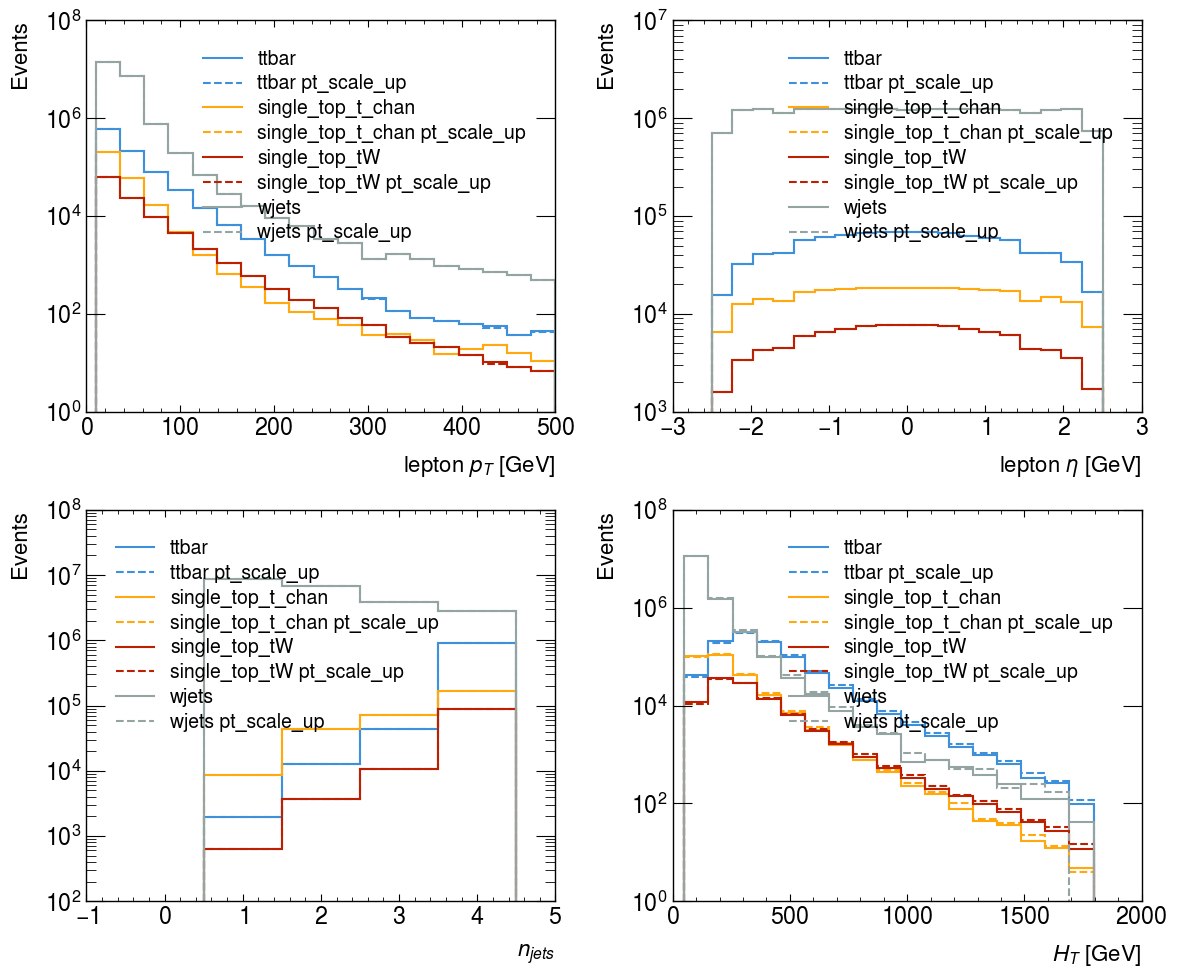

In [45]:
# Plot the training features to be used

bins_dict = {
    'lep_pt': np.linspace(10.0, 500.0, num=20),
    'lep_eta': np.linspace(-2.5, 2.5, num=20),
    'lep_phi': np.linspace(-2.5, 2.5, num=20),
    'H_T': np.linspace(50.0, 2000.0, num=20),
    'n_jets': np.linspace(-0.5, 4.5, num=6)
}

data_dict = {
    'lep_pt': 0,  # Column index for lep_pt
    'lep_eta': 1, # Column index for lep_eta
    'lep_phi': 2, # Column index for lep_phi
    'H_T': 3,     # Column index for H_T
    'n_jets': 4       # Column index for n_jets
}

xlabel_dict = {
    'lep_pt': 'lepton $p_T$ [GeV]', 
    'lep_eta': 'lepton $\eta$ [GeV]', 
    'lep_phi': 'lepton $\phi$ [GeV]', 
    'H_T': '$H_T$ [GeV]',     
    'n_jets': '$n_{jets}$'      
}

histograms = {}
for key, bin_edges in bins_dict.items():
    histograms[key] = {}
    for label in labels_dict:
        mask_process = (train_labels == labels_dict[label]) & (syst_labels=="nominal")
        histograms[key][label], _ = np.histogram(
            features[:, data_dict[key]][mask_process], 
            weights=weights[mask_process], 
            bins=bin_edges
        )
        print(histograms[key][label])

histograms_var_pT_res = {}
for key, bin_edges in bins_dict.items():
    histograms_var_pT_res[key] = {}
    for label in labels_dict:
        mask_process = (train_labels == labels_dict[label]) & (syst_labels=="pt_scale_up")
        histograms_var_pT_res[key][label], _ = np.histogram(
            features[:, data_dict[key]][mask_process], 
            weights=weights[mask_process], 
            bins=bin_edges
        )


palette = plt.rcParams['axes.prop_cycle'].by_key()['color']

color_label_map = {
    label: palette[i % len(palette)]
    for i,label in enumerate(labels_dict)
}


fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

plot_labels = ['lep_pt', 'lep_eta', 'n_jets', 'H_T']

for i, key in enumerate(plot_labels):
    for label in labels_dict:
        hep.histplot(histograms[key][label], bins=bins_dict[key], label=label, ax=axes[i], linewidth=1.5, color=color_label_map[label])
        hep.histplot(histograms_var_pT_res[key][label], bins=bins_dict[key], label=f"{label} pt_scale_up", ax=axes[i], linewidth=1.5, linestyle='--', color=color_label_map[label])

    axes[i].set_yscale('log')
    axes[i].set_xlabel(xlabel_dict[key], size=16)
    axes[i].set_ylabel('Events', size=16)
    axes[i].legend()

plt.tight_layout()
plt.show()


After processing and saving all the data, we move to the second notebook - `Neural_Likelihood_Ratio_training.ipynb`